# Optimizing the outflow problem

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt


from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor


In [2]:
path = '../../data/clean/'
SEED = 12


## Step 0: Naive model (RW)

First, let's load our main dataset with UNCHR covariates and consider the list of countries to make outflow predictions on.

In [3]:
data_outflows = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
       'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

data_outflows['year'] = pd.to_datetime(data_outflows['year'], format='%Y')
data_outflows = pd.concat([data_outflows.drop('newarrival',axis=1).groupby(['iso_o', 'year']).first(),data_outflows.groupby(['iso_o', 'year']).newarrival.sum()],axis=1)
data_outflows = data_outflows.reset_index()
data_outflows["year"] = data_outflows["year"].dt.year

In [4]:
# Rename target column
data_outflows = data_outflows.rename(columns={'newarrival': 'ref_outflow'})

data_outflows.shape


(4900, 19)

In [5]:
# Store the list of countries to predict

iso_3 = data_outflows.iso_o.unique().tolist()

len(iso_3)

196

In [6]:
# Create train/test split
test_time_start = 2018
test_time_end = 2021
train = data_outflows.loc[data_outflows.year < test_time_start]
test = data_outflows.loc[(data_outflows.year >= test_time_start) & (data_outflows.year <= test_time_end)]

In [7]:
y_naive = model_helpers.apply_naive_prediction(train, test, target="ref_outflow", lst_countries=iso_3,
                                              country_var='iso_o'
                                              )


In [8]:
mse_naive = mean_squared_error(y_pred=y_naive, y_true=test.ref_outflow, squared=False)
print("Mse Naive RW: " + str(mse_naive))

Mse Naive RW: 107566.00479382047


In [9]:
data = {
    'iso_o': test.iso_o,
    'year': test.year,
    'y_test': test.ref_outflow,
    'y_naive': y_naive
}
predictions = pd.DataFrame(data)
predictions

,iso_o,year,y_test,y_naive
18,ABW,2018,0.0,1.0
19,ABW,2019,1.0,0.0
20,ABW,2020,0.0,1.0
21,ABW,2021,0.0,0.0
43,AFG,2018,118015.0,128373.0
...,...,...,...,...
4871,ZMB,2021,73.0,86.0
4893,ZWE,2018,1908.0,4523.0
4894,ZWE,2019,3371.0,1908.0
4895,ZWE,2020,1196.0,3371.0


## Step 1: Baseline RF using UNCHR covariates and lags for selected features

In [10]:
data_outflows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iso_o             4900 non-null   object 
 1   year              4900 non-null   int32  
 2   pop_o             4900 non-null   float64
 3   CPI_o             4900 non-null   float64
 4   GDP_PP_o          4900 non-null   float64
 5   GDP_PPP_o         4900 non-null   float64
 6   island_o          4900 non-null   int64  
 7   area_o            4900 non-null   float64
 8   landlocked_o      4900 non-null   int64  
 9   PR_o              4900 non-null   int64  
 10  CL_o              4900 non-null   int64  
 11  typeOfViolence_o  4900 non-null   int64  
 12  best_est_o        4900 non-null   float64
 13  Nyear_conflict_o  4900 non-null   float64
 14  Nyear_log_o       4900 non-null   float64
 15  dead_log_o        4900 non-null   float64
 16  Nyear_conf_o      4900 non-null   int64  


In [11]:
data_outflows.columns

Index(['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o',
       'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o',
       'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o',
       'Nyear_conf_o', 'dead_o', 'ref_outflow'],
      dtype='object')

In [12]:
shift_cols_3 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_2 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]



Generating all this lags will cause us to have a bunch of nan values, which we want to avoid to be able to run RF.

I'll impute the first available value to the lag series that are missing with the helper function available in model_helpers.

In [13]:
shifted_df_filled_2 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_2, range(1, 3), 'iso_o', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_3, range(1, 4), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_2.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_3.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

In [14]:
data_outflows_lags.columns

Index(['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o',
       'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o',
       'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o',
       'Nyear_conf_o', 'dead_o', 'ref_outflow', 'Shift_1_CPI_o',
       'Shift_1_GDP_PP_o', 'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o', 'Shift_2_CPI_o',
       'Shift_2_GDP_PP_o', 'Shift_2_GDP_PPP_o', 'Shift_2_PR_o', 'Shift_2_CL_o',
       'Shift_2_Nyear_conflict_o', 'Shift_2_Nyear_log_o',
       'Shift_2_typeOfViolence_o', 'Shift_2_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o', 'Shift_3_ref_outflow',
       'Shift_3_dead_o', 'Shift_3_best_est_o', 'Shift_3_dead_log_o'],
      dtype='object')

Apart from lags, we might want to add rolling sums for:
- best estimate for casualties from conflict
- refugee outflows

In [15]:
window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

panel_data

,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,PR_o,...,Shift_3_ref_outflow,Shift_3_dead_o,Shift_3_best_est_o,Shift_3_dead_log_o,rolling_sum_past_3_ref_outflow,rolling_sum_past_5_ref_outflow,rolling_sum_past_10_ref_outflow,rolling_sum_past_3_best_est_o,rolling_sum_past_5_best_est_o,rolling_sum_past_10_best_est_o
0,ABW,2000,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,2001,0.091,2.518,37813.88,0.006,1,193.0,0,5,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,2002,0.092,4.162,37198.23,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,2003,0.093,2.287,37185.65,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,2004,0.095,2.774,39054.94,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,ZWE,2020,15.189,348.586,2048.27,0.025,0,390759.0,1,6,...,4523.0,0.0,0.0,0.000000,10998.0,39054.0,301203.0,14.0,14.0,16.0
4896,ZWE,2021,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,1908.0,0.0,4.0,1.386294,7115.0,21073.0,152453.0,16.0,16.0,18.0
4897,ZWE,2022,15.817,547.255,2171.10,0.025,0,390759.0,1,6,...,3371.0,0.0,8.0,2.079442,5207.0,11638.0,99862.0,14.0,18.0,19.0
4898,ZWE,2023,16.164,100.000,2184.84,0.025,0,390759.0,1,6,...,1196.0,0.0,2.0,0.693147,1836.0,7115.0,78325.0,8.0,20.0,20.0


We generate data for continents

In [16]:
continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)

Finally, we drop the columns that we wouldn't know the value for the same year we are forecasting. That is, we keep only shifted variables and rolling sums, and some descriptive variables (e.g. is island, etc.)

In [17]:
unhcr = unhcr.drop(columns=['CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'PR_o', 'CL_o',
       'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
       'dead_log_o', 'Nyear_conf_o', 'dead_o'])

Binary encoding and scaling

In [18]:
unhcr.columns

Index(['iso_o_continent', 'iso_o', 'year', 'pop_o', 'island_o', 'area_o',
       'landlocked_o', 'ref_outflow', 'Shift_1_CPI_o', 'Shift_1_GDP_PP_o',
       'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o', 'Shift_2_CPI_o',
       'Shift_2_GDP_PP_o', 'Shift_2_GDP_PPP_o', 'Shift_2_PR_o', 'Shift_2_CL_o',
       'Shift_2_Nyear_conflict_o', 'Shift_2_Nyear_log_o',
       'Shift_2_typeOfViolence_o', 'Shift_2_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o', 'Shift_3_ref_outflow',
       'Shift_3_dead_o', 'Shift_3_best_est_o', 'Shift_3_dead_log_o',
       'rolling_sum_past_3_ref_outflow', 'rolling_sum_past_5_ref_outflow',
       'rolling_sum_past_10_ref_outflow', 'rolling_sum_past_3_best_est_o',
       'rolling_sum_past_5_

In [19]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', "Shift_2_typeOfViolence_o"]

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(unhcr.columns) - set(binary_cols  + ['year', 'ref_outflow']))



transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(random_state=SEED))])

In [20]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr, 'ref_outflow', test_time_start, test_time_end, 'year')

In [21]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1', BinaryEncoder(),
                                                  ['iso_o', 'iso_o_continent',
                                                   'Shift_1_typeOfViolence_o',
                                                   'Shift_2_typeOfViolence_o']),
                                                 ('num', RobustScaler(),
                                                  ['area_o',
                                                   'Shift_3_dead_log_o',
                                                   'Shift_1_ref_outflow',
                                                   'Shift_2_GDP_PP_o',
                                                   'Shift_1_best_est_o',
                                                   'Shift_2_Nyear_conf_o',
                                                   'Shift_3_best_es...
                                                   'Shift_2_GDP_PPP_o',
                                                   'Shift_1_CL_o',
                                                   'Shift_2_ref_outflow',
                                                   'rolling_sum_past_5_best_est_o',
                                                   'Shift_3_dead_o',
                                                   'Shift_1_Nyear_conf_o',
                                                   'Shift_2_dead_o',
                                                   'Shift_2_best_est_o',
                                                   'Shift_1_GDP_PP_o',
                                                   'Shift_2_PR_o',
                                                   'landlocked_o', 'island_o',
                                                   'Shift_1_PR_o',
                                                   'Shift_2_CL_o',
                                                   'Shift_2_Nyear_conflict_o',
                                                   'Shift_1_dead_log_o', ...])])),
                ('rf', RandomForestRegressor(random_state=12))])

In [22]:
y_pred = rf_pipe.predict(X_test)

y_pred = np.clip(y_pred, 0, None)

In [23]:
mse_unhcr = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - UNHCR covariates only: " + str(mse_unhcr))
print("Relative RMSE to Naive predictions: " + str(mse_unhcr/mse_naive))

RMSE outflows - UNHCR covariates only: 87189.12370829062
Relative RMSE to Naive predictions: 0.810563931191944


In [24]:
predictions["y_unhcr"]=y_pred

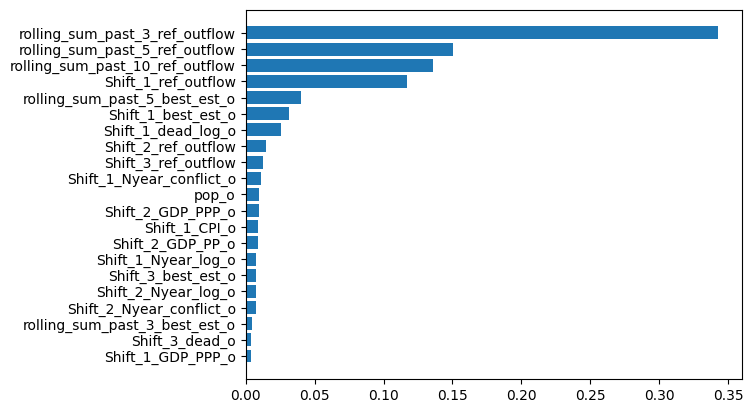

In [25]:
# Get feature importances from random forest model
importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)


## Step 2: Adding Google Trends data

#### Version 1:
+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ unweighted trends

In [26]:
english_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_EN.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
ol_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_orig_lang.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])
ol_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_OL.csv").drop_duplicates()

topics = pd.read_csv("../trends/data/semantic_topic_trends_2005.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
# topics.info() - nulls in country, dropping those
topics = topics[topics.country.isnull()==False]
print(topics.shape)

print(english_from_topics.shape)
# english_boss.info() # A bunch of missing dates - idk what happened there!
# We can't do much without dates so I'm dropping them - will have to check if it's worth re-downloading this 
english_boss = english_boss[english_boss.date.isnull()==False].drop(columns=["index"])
print(english_boss.shape)


# I downloaded data for a maximum of two origin languages. This might not be the best approach, but for now, I'm averaging the values when I have more than one OL.
ol_from_topics_av = ol_from_topics.groupby(['country', 'date']).mean().reset_index()
ol_boss_av = ol_boss.groupby(['country', 'date']).mean().reset_index()
# Print the transformed dataset
print(ol_from_topics_av.shape)
print(ol_boss_av.shape)

C:\Users\danid\AppData\Local\Temp\ipykernel_5288\31775143.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])


(42098, 8)
(21816, 22)
(12096, 41)
(30240, 22)
(27216, 41)


Big merge:

In [27]:
# Let's merge first keywords - english and OL - separately

english = pd.merge(english_from_topics, english_boss, on=["date", "country"], how="outer")
ol = pd.merge(ol_from_topics_av, ol_boss_av, on=["date", "country"], how="outer")
print(english.shape)
print(ol.shape)

# Get the keywords listed 
keywords = english.columns[~english.columns.isin(['country', 'date'])]
print(keywords)
topics_list = topics.columns[~topics.columns.isin(['country', 'date'])]
print(topics_list)

(24408, 61)
(30240, 61)
Index(['passport', 'Immigration', 'Travel Visa', 'Refugee', 'Conflict', 'War',
       'Violence', 'Crisis', 'Militia', 'Genocide', 'Armed Forces', 'Civilian',
       'Currency', 'Lottery', 'Economy', 'Wage', 'Protest', 'Government',
       'Bureau de change', 'Coup d’état', 'asylum', 'citizen',
       'citizenship+citizenships', 'consulate+consulates', 'crises+crisis',
       'diaspora', 'embassy+embassies', 'emigration', 'foreigner+foreigners',
       'immigrant+immigrants', 'migrate', 'migration',
       'nationality+nationalities', 'recruitment+recruitments',
       'refugee+refugees', 'repatriation', 'Schengen', 'student visa',
       'visa free', 'visa+visas', 'work visa', 'emigrant+emigrants',
       'devaluation', 'immigrate+immigrated',
       'legalization+legalisation+legalisations+legalizations',
       'naturalization+naturalisation+naturalisations+naturalizations',
       'recession+recessions', 'smuggler+smugglers+smuggling',
       'deportation+de

In [28]:
# Create a mapping dictionary for renaming the columns
rename_dict_ol = {var: f"{var}_ol" for var in keywords}
rename_dict_en = {var: f"{var}_en" for var in keywords}
rename_dict_topics = {var: f"{var}_topic" for var in topics_list}
# Rename the columns using the mapping dictionary

english_2 = english.copy()
ol_2 = ol.copy()
topics_2 = topics.copy()

english_2.rename(columns=rename_dict_en, inplace=True)
ol_2.rename(columns=rename_dict_ol, inplace=True)
topics_2.rename(columns=rename_dict_topics, inplace=True)

In [29]:
big_merge = pd.merge(english_2, ol_2, on=["country", "date"], how="outer").merge(topics_2, on=["country", "date"], how="outer")
print(big_merge.shape)
print(big_merge.columns)

(42530, 126)
Index(['date', 'passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=126)


Average and max values in the year:

In [30]:
avg_trends = big_merge.copy()
avg_trends["iso_o"] = avg_trends["country"].apply(lambda x: model_helpers.convert_iso2_to_iso3(x))
avg_trends.set_index('date', inplace=True)
avg_trends.index = pd.DatetimeIndex(avg_trends.index)
avg_trends = avg_trends.drop(columns=["country"])

# Group by 'iso_o' and resample by YEAR, then mean the values

avg_trends_1 = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).mean().reset_index()
avg_trends_1['year'] = avg_trends_1['date'].dt.year
avg_trends_1 = avg_trends_1.drop(columns=["date"])

# Taking max 

max_trends = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).max().reset_index()
max_trends['year'] = max_trends['date'].dt.year
max_trends = max_trends.drop(columns=["date"])

keywords_new = avg_trends_1.columns[~avg_trends_1.columns.isin(['iso_o', 'year'])]

# Create a mapping dictionary for renaming the columns
rename_dict_avg = {var: f"{var}_avg" for var in keywords_new}
rename_dict_min = {var: f"{var}_min" for var in keywords_new}
rename_dict_max = {var: f"{var}_max" for var in keywords_new}

avg_trends_1.rename(columns=rename_dict_avg, inplace=True)
max_trends.rename(columns=rename_dict_max, inplace=True)

print(avg_trends_1.shape)
print(max_trends.shape)

(3722, 126)
(3722, 126)


Rolling sums (all vars)

In [31]:
# First: monthly aggregation - the data comes monthly automatically when downloading large periods, 
# but because we are not controlling that necessarily during download, just in case

monthly = avg_trends.groupby(['iso_o', pd.Grouper(freq='M')]).mean().reset_index()
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly = monthly.drop(columns=["date"])
monthly.shape # it's actually not necessary, same shape

(42530, 127)

In [32]:
final_keywords_list = monthly.columns[~monthly.columns.isin(['year', 'month', 'iso_o'])]
print(final_keywords_list)

Index(['passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       'Genocide_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=124)


In [33]:
window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
group_cols = ['iso_o', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(monthly, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==1]

panel_trends

,iso_o,passport_en,Immigration_en,Travel Visa_en,Refugee_en,Conflict_en,War_en,Violence_en,Crisis_en,Militia_en,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,ABW,0.0,0.0,NaN,0.0,18.0,0.0,0.0,60.0,NaN,...,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.0
24,ABW,0.0,27.0,NaN,42.0,0.0,43.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,23.0,23.0,46.0,46.0,0.0,0.0
36,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,12.0,12.0,0.0,0.0,22.0,22.0,0.0,0.0,10.0,10.0
48,ABW,0.0,0.0,NaN,0.0,0.0,8.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42481,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,22.0,22.0,2.0,2.0,8.0,8.0,10.0,10.0
42493,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,31.0,31.0,2.0,2.0,8.0,8.0,7.0,7.0
42505,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,12.0,12.0,0.0,0.0,11.0,11.0,8.0,8.0
42517,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,25.0,25.0,2.0,2.0,13.0,13.0,8.0,8.0


In [34]:
trends_final = pd.merge(avg_trends_1, max_trends, how='outer', on=["iso_o", "year"])
trends_final = pd.merge(trends_final, panel_trends.drop(columns=["month"]), how='outer', on=["iso_o", "year"])
trends_final

,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,23.833333,12.166667,NaN,24.333333,13.416667,9.416667,8.333333,5.250000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,0.000000,0.000000,NaN,1.916667,10.583333,23.583333,4.083333,16.583333,NaN,...,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.0
2,ABW,2.583333,5.833333,NaN,10.666667,3.416667,16.250000,0.000000,10.583333,NaN,...,0.0,0.0,0.0,0.0,23.0,23.0,46.0,46.0,0.0,0.0
3,ABW,4.333333,3.916667,NaN,5.166667,2.583333,10.666667,4.250000,7.083333,NaN,...,12.0,12.0,0.0,0.0,22.0,22.0,0.0,0.0,10.0,10.0
4,ABW,2.416667,4.333333,NaN,0.000000,2.666667,10.583333,2.250000,5.416667,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,22.0,22.0,2.0,2.0,8.0,8.0,10.0,10.0
3718,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,31.0,31.0,2.0,2.0,8.0,8.0,7.0,7.0
3719,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,12.0,12.0,0.0,0.0,11.0,11.0,8.0,8.0
3720,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,25.0,25.0,2.0,2.0,13.0,13.0,8.0,8.0


NaN imputation - replace with 0, assuming very low searches/no searches

In [35]:
trends_final = trends_final.fillna(0)

Let's try a first text-based model, without further transformations.

In [36]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow"]]
trends_final_y = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
print(trends_final.shape)
print(trends_final_y.shape) # some trends weren't picked up at all for some countries
trends_final_y = trends_final_y.fillna(0)


(3722, 622)
(3994, 623)


In [37]:
trends_final_y["target"] = trends_final_y.groupby('iso_o').ref_outflow.shift(-1)
trends_final_y = trends_final_y.drop(columns=["ref_outflow"])

In [38]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_final_y.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED))])

In [39]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_final_y, 'target', test_time_start, test_time_end, 'year')

In [40]:
rf_pipe.fit(X_train, y_train)


y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only: " + str(mse_trends))
print("Relative RMSE to Naive predictions: " + str(mse_trends/mse_naive))


RMSE outflows - GTrends only: 110701.97063670456
Relative RMSE to Naive predictions: 1.0291538748593947


Without any historical data, just google trends gives us slightly worse results that the naive model. However, it does seem to hold predictive power.

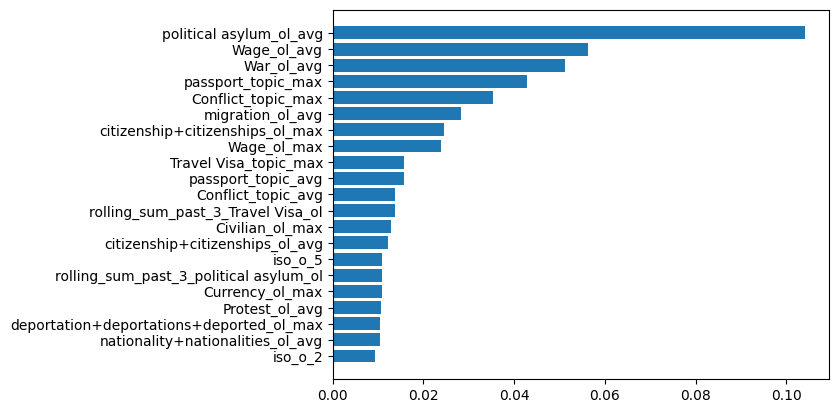

In [41]:
# Get feature importances from random forest model
importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

#### Version 2:

+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ weighted trends - trends multiplied by population and internet penetration in the country

In [42]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

In [43]:
value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1 in the version to multiply
internet_long = internet_long.copy().fillna(1)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})


In [44]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow", "pop_o"]]
trends_merged = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"])

# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'year', 'pop_o', 'internet', 'ref_outflow']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
# columns_to_drop = ['internet', 'pop_o]
# trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged = trends_merged.fillna(0)
trends_merged.shape


(3528, 625)

IMPORTANT - I'M GENERATING THE TARGET VARIABLE ALREADY WITH FORECASTING IN MIND (SHIFTED BY 1)

In [45]:
trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)
trends_merged = trends_merged.drop(columns=["ref_outflow"])


C:\Users\danid\AppData\Local\Temp\ipykernel_5288\2165611857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)


Applying the same pipeline

In [46]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED))])

In [47]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [48]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends_weighted = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only (weighted): " + str(mse_trends_weighted))
print("Relative RMSE to Naive predictions: " + str(mse_trends_weighted/mse_naive))

RMSE outflows - GTrends only (weighted): 69070.74354712188
Relative RMSE to Naive predictions: 0.6421242815470813


Amazing improvement! Let's see how biased the predictions are in this case.

In [49]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_tw"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

# Compute RMSE for each row
predictions['naive_error'] = np.sqrt((predictions['y_test'] - predictions['y_naive']) ** 2)
predictions['RF_error_tw'] = np.sqrt((predictions['y_test'] - predictions['y_pred_tw']) ** 2)
# results_df['RF_outflow_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_outflow']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
predictions['actual_range'] = pd.cut(predictions['y_test'], ranges, labels=labels, include_lowest=True)

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_tw','actual_range']].groupby('actual_range').mean()
grouped_errors


C:\Users\danid\AppData\Local\Temp\ipykernel_5288\1453560760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_tw"]=y_pred


,naive_error,RF_error_tw
actual_range,,
0-10,10.247788,4032.380594
10-100,23.441176,4241.208147
100-1k,709.000000,16356.004741
1k-10k,1628.398907,15998.701612
10k-100k,20092.700787,30206.561024
100k+,213039.666667,192939.824667


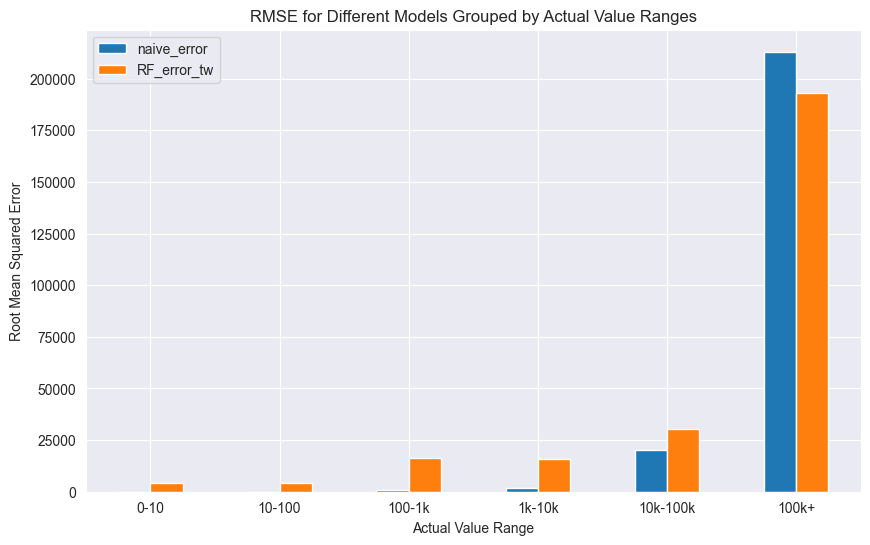

In [50]:
# Plot the bar plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()


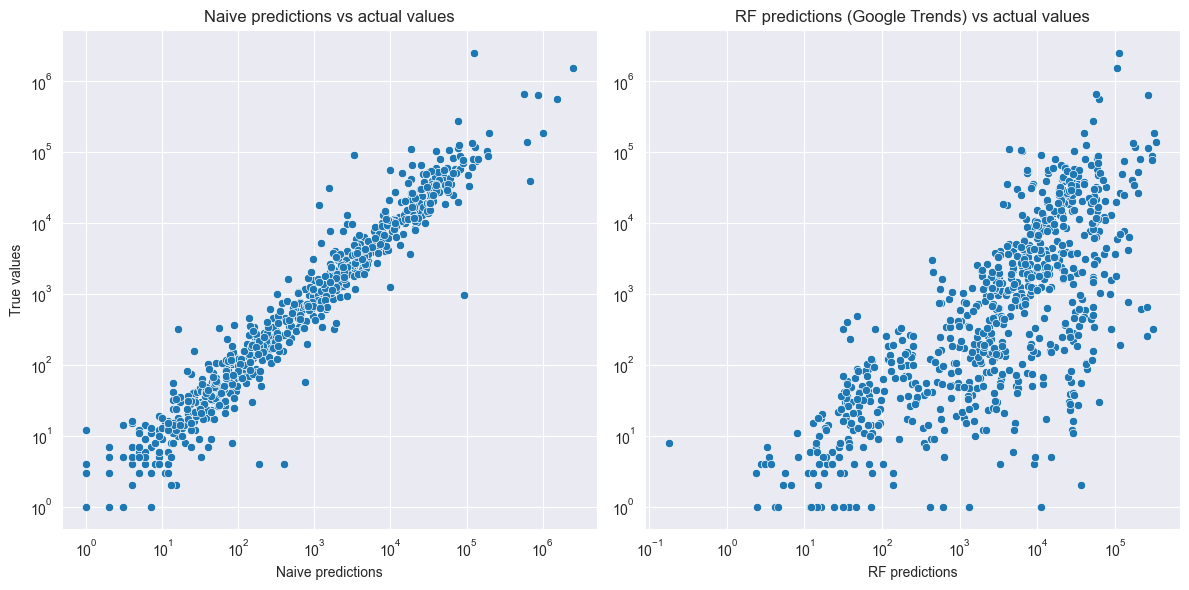

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions, x='y_naive', y='y_test', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions, x='y_pred_tw', y='y_test', ax=axes[1])
axes[1].set_xlabel('RF predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('RF predictions (Google Trends) vs actual values')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

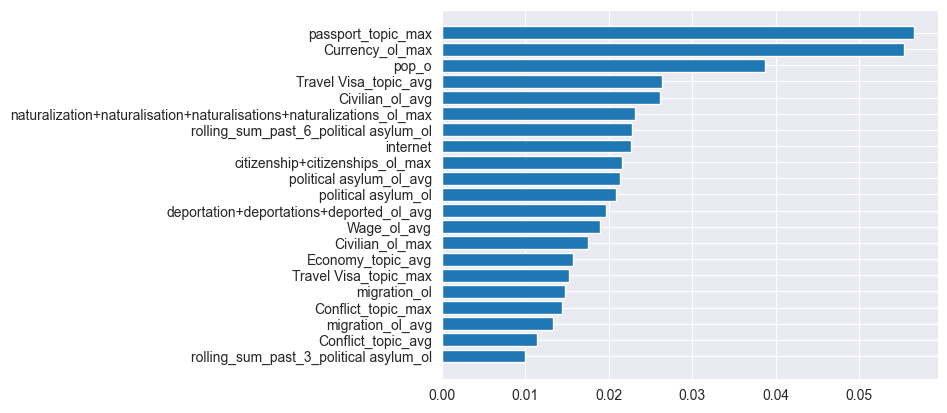

In [52]:
# Get feature importances from random forest model
importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

#### Version 3. 

Instead of weighting, I'll try what happens just including pop_o and internet as controls.

In [53]:
# data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
# data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow", "pop_o"]]
# trends_merged = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
# trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"])

# trends_merged = trends_merged.fillna(0)
# trends_merged.shape


In [54]:
# trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)
# trends_merged = trends_merged.drop(columns=["ref_outflow"])

In [55]:
# binary_cols = ['iso_o']

# # numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
# numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

# from sklearn.compose import ColumnTransformer

# transform_cols = ColumnTransformer(
#     [
#         ('cat1', be, binary_cols),
#    #     ('cat2', ohe, ohe_cols),
#         ('num', cont_scaler, numerical_cols)
#     ],
#     remainder='passthrough'
# )

# rf_pipe = Pipeline([('preprocessing', transform_cols),
#                     ('rf', RandomForestRegressor(n_jobs=-1))])

In [56]:
# X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [57]:
# rf_pipe.fit(X_train, y_train)

# y_pred = rf_pipe.predict(X_test)

# mse_trends_controls = mean_squared_error(y_test, y_pred, squared=False)

# print("RMSE outflows - GTrends only (with controls): " + str(mse_trends_controls))
# print("Relative RMSE to Naive predictions: " + str(mse_trends_controls/mse_naive))

Worse results - going back to the weighted version.

#### Version 4 - Reducing dimensionality

Here I'll use cosine similarity to merge similar keywords and make a model that is faster to train. This is not a problem now, but it will become one when we start adding covariates.

In [58]:
# Preprocess in another notebook

# This might be relevant if the other covariates become too much, but for now it's not necessary to implement

## Step 3. Augmented model: UNHCR covariates + Google Trends

IMPORTANT NOTE ABOUT THE Y: when I first implemented the UNHCR baseline model, I lagged all of the covariates by 1 and dropped the originals.

Here, because I will be merging the UNHCR dataset to the trends dataset, and the trends dataset already has the `target` variable generated considering 1 shift, I will keep the UNHCR covariates as they are (besides considering some lags and rolling sums to add value to the prediction). 

In [59]:
print(trends_merged.shape)

(3528, 625)


In [60]:
shift_cols_3 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_1 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]

shifted_df_filled_1 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_1, range(1, 2), 'iso_o', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_3, range(1, 4), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_1.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_3.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)

unhcr = unhcr.drop(columns=["ref_outflow"])
len(unhcr.columns)

46

In [61]:
trends_merged = trends_merged.drop(columns=["pop_o"])
merged_trends_cov = pd.merge(trends_merged, unhcr, on=["iso_o", "year"], how="left")

merged_trends_cov = merged_trends_cov[merged_trends_cov.year<2022]


# def select_rows_with_nan(data):
#     return data[data.isnull().any(axis=1)]

# selected_rows = select_rows_with_nan(merged_trends_cov)

# selected_rows.shape

merged_trends_cov = merged_trends_cov.dropna()
print(merged_trends_cov.shape)
merged_trends_cov.head()

(3281, 668)


,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,Shift_3_ref_outflow,Shift_3_dead_o,Shift_3_best_est_o,Shift_3_dead_log_o,rolling_sum_past_3_ref_outflow,rolling_sum_past_5_ref_outflow,rolling_sum_past_10_ref_outflow,rolling_sum_past_3_best_est_o,rolling_sum_past_5_best_est_o,rolling_sum_past_10_best_est_o
0,ABW,59.325933,30.285267,0.0,60.570533,33.396767,23.439967,20.743333,13.068300,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,0.000000,0.000000,0.0,5.313000,29.337000,65.373000,11.319000,45.969000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,7.982500,18.025000,0.0,32.960000,10.557500,50.212500,0.000000,32.702500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,22.758667,20.570333,0.0,27.135333,13.567667,56.021333,22.321000,37.201667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,14.297000,25.636000,0.0,0.000000,15.776000,62.611000,13.311000,32.045000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(merged_trends_cov.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED))])

In [63]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(merged_trends_cov, 'target', test_time_start, test_time_end, 'year')


In [64]:
merged_trends_cov.shape

(3281, 668)

In [65]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))

RMSE outflows - GTrends + UNHCR covariates: 72332.82332523937
Relative RMSE to Naive predictions: 0.6724505894207461


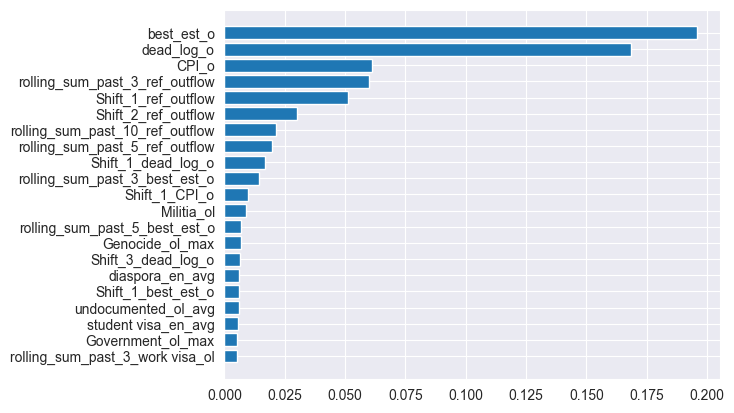

In [66]:
# Get feature importances from random forest model
importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

In [67]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

predictions

C:\Users\danid\AppData\Local\Temp\ipykernel_5288\690484936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug"]=y_pred


,iso_o,year,y_test,y_naive,y_unhcr,y_pred_tw,naive_error,RF_error_tw,actual_range,y_pred_aug
0,ABW,2018,0.0,1.0,0.25,10910.97,1.0,10910.97,0-10,0.510
1,ABW,2019,1.0,0.0,0.65,11311.04,1.0,11310.04,0-10,0.550
2,ABW,2020,0.0,1.0,0.38,12818.41,1.0,12818.41,0-10,0.730
3,ABW,2021,0.0,0.0,0.39,11310.12,0.0,11310.12,0-10,0.430
4,AFG,2018,118015.0,128373.0,296406.37,183832.49,10358.0,65817.49,100k+,375290.560
...,...,...,...,...,...,...,...,...,...,...
779,ZMB,2021,73.0,86.0,128.48,5364.65,13.0,5291.65,10-100,144.160
780,ZWE,2018,1908.0,4523.0,7026.00,13475.58,2615.0,11567.58,1k-10k,19599.040
781,ZWE,2019,3371.0,1908.0,5026.18,16466.14,1463.0,13095.14,1k-10k,40347.655
782,ZWE,2020,1196.0,3371.0,3243.44,14028.61,2175.0,12832.61,1k-10k,17522.940


In [68]:

# Compute RMSE for each row
predictions['RF_error_aug'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug']) ** 2)
predictions['RF_error_unhcr'] = np.sqrt((predictions['y_test'] - predictions['y_unhcr']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
predictions['actual_range'] = pd.cut(predictions['y_test'], ranges, labels=labels, include_lowest=True)

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_unhcr', 'RF_error_tw', 'RF_error_aug', 'actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,RF_error_unhcr,RF_error_tw,RF_error_aug
actual_range,,,,
0-10,10.247788,8.436106,4032.380594,216.483069
10-100,23.441176,22.139706,4241.208147,55.675529
100-1k,709.000000,471.197816,16356.004741,2073.841954
1k-10k,1628.398907,3392.739180,15998.701612,7335.051393
10k-100k,20092.700787,37264.219370,30206.561024,44995.198701
100k+,213039.666667,296695.927333,192939.824667,133158.890667


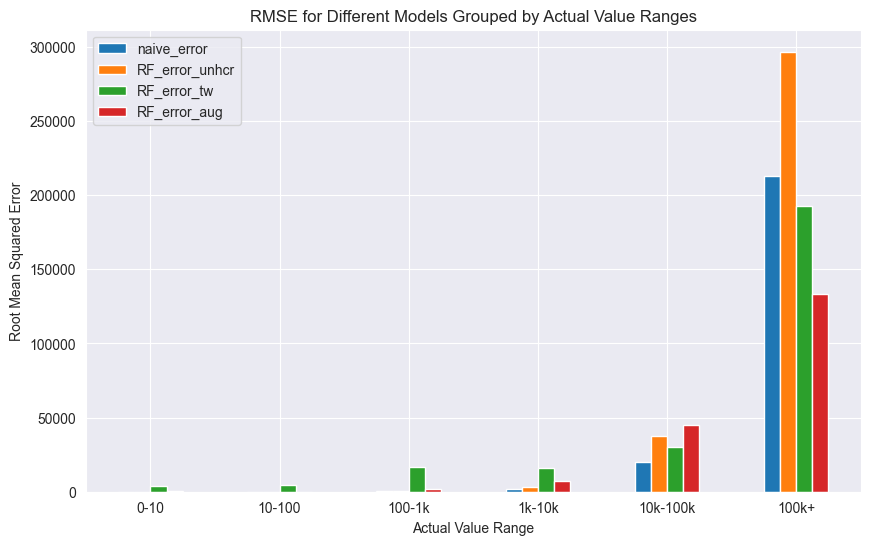

In [69]:
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

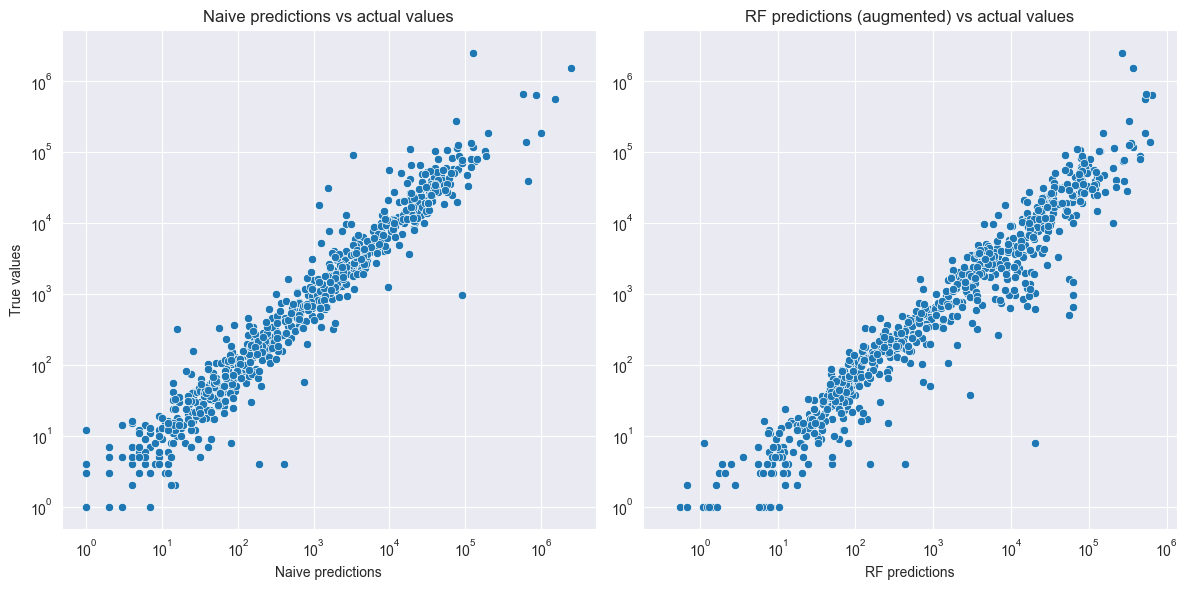

In [70]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions, x='y_naive', y='y_test', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions, x='y_pred_aug', y='y_test', ax=axes[1])
axes[1].set_xlabel('RF predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('RF predictions (augmented) vs actual values')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [71]:
# # Hyperparameter tunning
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'rf__max_features': [0.3, 1, 25, 50, 100, 110, 130, 150, 200, 300, 400],
#     'rf__n_estimators': [50, 100, 120, 150, 200, 300, 350, 400, 500],
#     'rf__max_depth': [None, 3, 5, 10, 15, 16, 17, 20, 25, 30],
#     'rf__random_state': [123]
# }

# # Create the GridSearchCV object
# grid_search = HalvingGridSearchCV(rf_pipe, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# grid_search.fit(X_train, y_train)  

# # Retrieve the best model and its corresponding parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Print the best parameters
# print("Best parameters:", best_params)

# y_pred = grid_search.predict(X_test)

# mse_aug_tunned = mean_squared_error(y_test, y_pred, squared=False)

# print("RMSE outflows - GTrends + UNHCR covariates (tunned): " + str(mse_aug_tunned))
# print("Relative RMSE to Naive predictions: " + str(mse_aug_tunned/mse_naive))


Different models:

In [72]:
# Define the models you want to include
models = [
    ('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED)),
    ('xgb', XGBRegressor(random_state=SEED)),
    ('ada', AdaBoostRegressor(random_state=SEED)),
    ('gb', GradientBoostingRegressor(random_state=SEED))
]

# Define the preprocessing steps
transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

trained_models = {}

for model_name, model in models:
    # Create the pipeline for the current model
    pipeline = Pipeline([
        ('preprocessing', transform_cols),
        ('model', model)
    ])

    # Fit the pipeline to your data
    pipeline.fit(X_train, y_train)  # Replace X and y with your input data

    # Store the fitted model in the dictionary
    trained_models[model_name] = pipeline

    y_pred = pipeline.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_pipe = mean_squared_error(y_test, y_pred, squared=False)

    print("RMSE outflows - " + model_name + ": " + str(mse_pipe))
    print("Relative RMSE to Naive predictions: " + str(mse_pipe/mse_naive))



RMSE outflows - rf: 72332.82332523937
Relative RMSE to Naive predictions: 0.6724505894207461
RMSE outflows - xgb: 74002.87832792019
Relative RMSE to Naive predictions: 0.6879764519447092
RMSE outflows - ada: 95333.27226997846
Relative RMSE to Naive predictions: 0.8862769650384491
RMSE outflows - gb: 66895.6720260177
Relative RMSE to Naive predictions: 0.6219034736322266


Gradient Boosting has the best results. Let's try hyperparameter tunning on it.

In [73]:
# from sklearn.ensemble import GradientBoostingRegressor

# # Define the model
# gb_model = GradientBoostingRegressor()

# # Define the parameter grid
# param_grid = {
#     'model__max_features': [1, 10, 20, 25, 50, 100, 130, 150, 200, 300],
#     'model__n_estimators': [50, 100, 120, 150, 200, 300, 400, 500],
#     'model__max_depth': [None, 3, 5, 10, 15, 20, 30],
#     'model__learning_rate': [0.01, 0.1],
#     'model__random_state': [123]
# }

# # Create the pipeline
# pipeline = Pipeline([
#     ('preprocessing', transform_cols),
#     ('model', gb_model)
# ])

# # Create the GridSearchCV object
# grid_search = HalvingGridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# # Retrieve the best model and its corresponding parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Print the best parameters
# print("Best parameters:", best_params)

# y_pred = grid_search.predict(X_test)

# mse_aug_tuned = mean_squared_error(y_test, y_pred, squared=False)

# print("RMSE outflows - GTrends + UNHCR covariates (tuned): " + str(mse_aug_tuned))
# print("Relative RMSE to Naive predictions: " + str(mse_aug_tuned / mse_naive))


Haven't found a good combination of parameters to improve the default values.

Let's keep the default gradient boosting and add the rmse analysis.

In [74]:
trained_models["gb"]

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1', BinaryEncoder(),
                                                  ['iso_o', 'iso_o_continent',
                                                   'Shift_1_typeOfViolence_o',
                                                   'typeOfViolence_o']),
                                                 ('num', RobustScaler(),
                                                  ['embassy+embassies_ol',
                                                   'repatriation_en_avg',
                                                   'rolling_sum_past_6_emigrate+emigrated_en',
                                                   'rolling_sum_past_3_asylum '
                                                   'seeker_ol',
                                                   'Genocide_en...
                                                   'political refugee_ol',
                                                   'rolling_sum_past_3_Violence_ol',
                                                   'Nyear_log_o',
                                                   'rolling_sum_past_6_recession+recessions_en',
                                                   'visa free_en_avg',
                                                   'rolling_sum_past_6_nationality+nationalities_ol',
                                                   'Shift_2_best_est_o',
                                                   'Protest_en',
                                                   'Economy_en_avg',
                                                   'rolling_sum_past_3_asylum_ol',
                                                   'Immigration_topic_max', ...])])),
                ('model', GradientBoostingRegressor(random_state=12))])

In [75]:
y_pred = trained_models["gb"].predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GB: " + str(mse_gb))
print("Relative RMSE to Naive predictions: " + str(mse_gb/mse_naive))

RMSE outflows - GB: 66948.72561507416
Relative RMSE to Naive predictions: 0.6223966925554186


In [76]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_gb"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

predictions.head()

C:\Users\danid\AppData\Local\Temp\ipykernel_5288\3341077336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_gb"]=y_pred


,iso_o,year,y_test,y_naive,y_unhcr,y_pred_tw,naive_error,RF_error_tw,actual_range,y_pred_aug,RF_error_aug,RF_error_unhcr,y_pred_gb
0,ABW,2018,0.0,1.0,0.25,10910.97,1.0,10910.97,0-10,0.51,0.51,0.25,508.021376
1,ABW,2019,1.0,0.0,0.65,11311.04,1.0,11310.04,0-10,0.55,0.45,0.35,508.021376
2,ABW,2020,0.0,1.0,0.38,12818.41,1.0,12818.41,0-10,0.73,0.73,0.38,508.021376
3,ABW,2021,0.0,0.0,0.39,11310.12,0.0,11310.12,0-10,0.43,0.43,0.39,508.021376
4,AFG,2018,118015.0,128373.0,296406.37,183832.49,10358.0,65817.49,100k+,375290.56,257275.56,178391.37,143237.008867


In [77]:
# Compute RMSE for each row
predictions['GB_error'] = np.sqrt((predictions['y_test'] - predictions['y_pred_gb']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_unhcr', 'RF_error_tw', 'RF_error_aug', 'GB_error', 'actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,RF_error_unhcr,RF_error_tw,RF_error_aug,GB_error
actual_range,,,,,
0-10,10.247788,8.436106,4032.380594,216.483069,1071.257707
10-100,23.441176,22.139706,4241.208147,55.675529,978.454704
100-1k,709.000000,471.197816,16356.004741,2073.841954,2558.427899
1k-10k,1628.398907,3392.739180,15998.701612,7335.051393,8567.185434
10k-100k,20092.700787,37264.219370,30206.561024,44995.198701,37736.574196
100k+,213039.666667,296695.927333,192939.824667,133158.890667,118768.420322


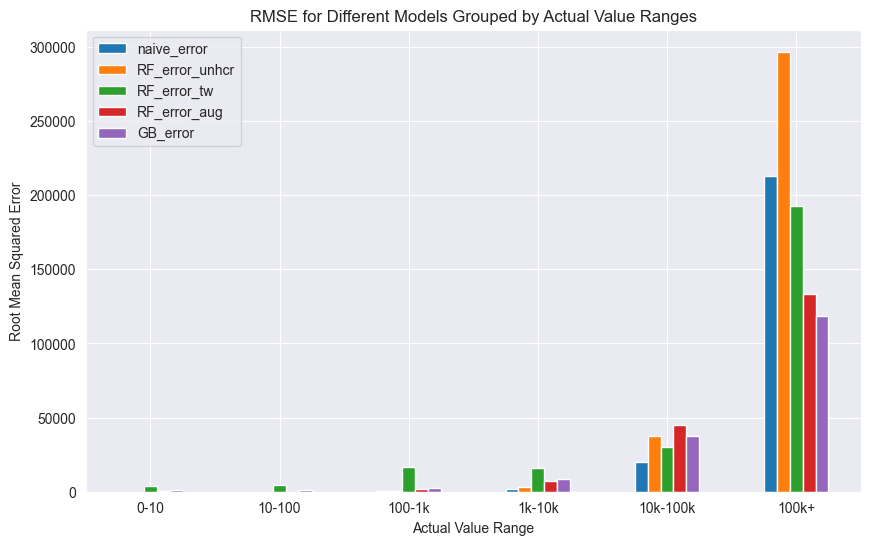

In [78]:
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

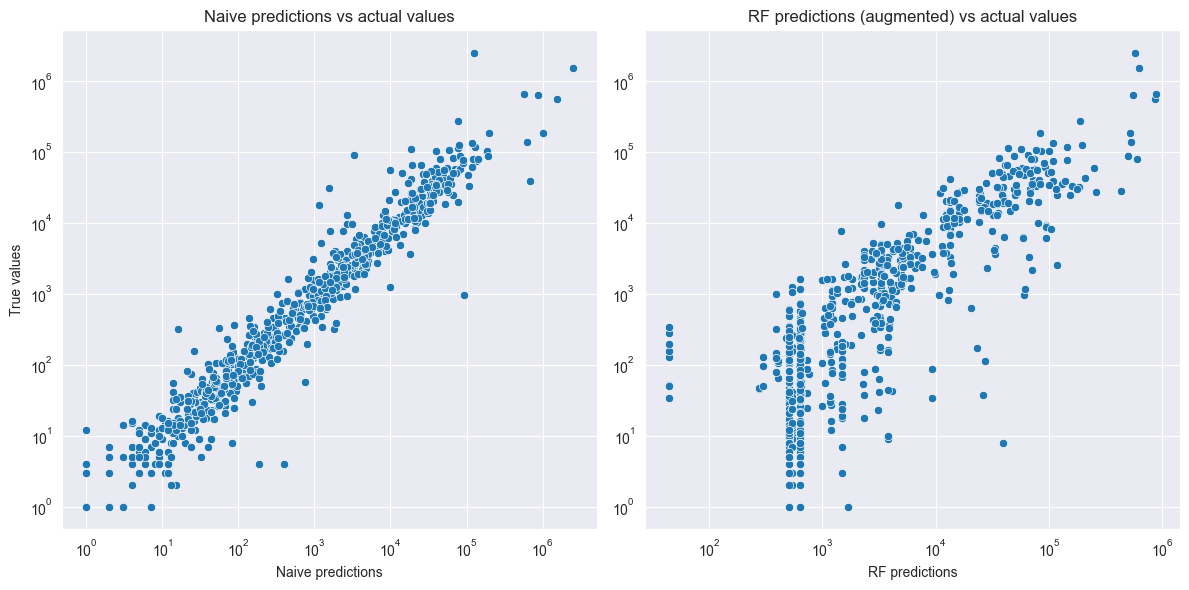

In [79]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions, x='y_naive', y='y_test', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions, x='y_pred_gb', y='y_test', ax=axes[1])
axes[1].set_xlabel('RF predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('RF predictions (augmented) vs actual values')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

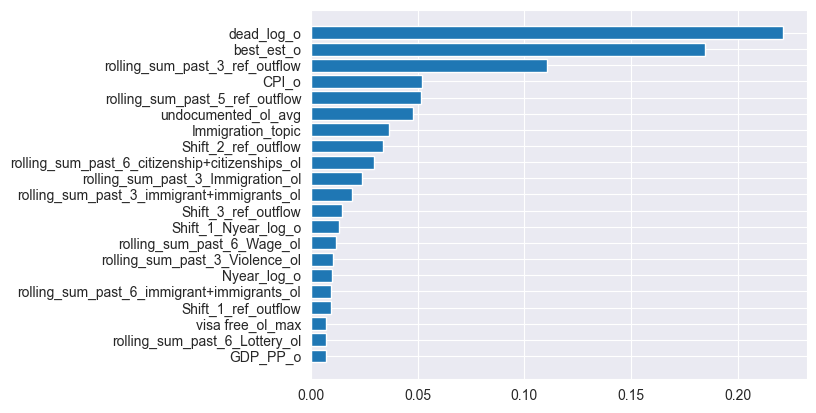

In [80]:
# Get feature importances from random forest model
importances = trained_models["gb"].named_steps['model'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(trained_models["gb"].named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

Before going to the next step, let's delete stuff to free up memory.

In [81]:
# Define the variables to keep
files_to_keep = ['data_outflows', 'predictions', 'merged_trends_cov', 'unhcr', 'mse_naive', "test_time_start", "test_time_end", "SEED"]

# Delete variables not in the files_to_keep list
variables_to_delete = [var_name for var_name in locals() if var_name not in files_to_keep and not var_name.startswith('_')]
for var_name in variables_to_delete:
    del locals()[var_name]

# Note: may need to re-run imports

## Step 4. Augmented model + extra covariates

In [82]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt


from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [83]:
import pandas as pd
import numpy as np

path = '../../data/clean/'

# yearly sources from the internet
idp = pd.read_csv(path + 'idp.csv', engine='pyarrow')
fsi = pd.read_csv(path + 'fragility_indices.csv', engine='pyarrow')
migration = pd.read_csv(path + 'migration_stocks.csv')


#### MIGRATION

First step: focus on origin countries for the outflow problem

In [84]:
migration = migration.groupby(['iso_o', 'year'])['migration_stock'].sum().reset_index()

migration['migration_change'] = migration.groupby('iso_o')['migration_stock'].pct_change() * 100

migration = migration.fillna(0)


In [85]:
aug_1 = pd.merge(merged_trends_cov, migration, on=["iso_o", "year"], how="left")
print(migration.shape)
print(aug_1.shape)
print(merged_trends_cov.shape)
aug_1["migration_stock_weighted"] = aug_1["migration_stock"]/aug_1["pop_o"]

(4900, 4)
(3281, 670)
(3281, 668)


C:\Users\danid\AppData\Local\Temp\ipykernel_5288\1238760211.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug_1["migration_stock_weighted"] = aug_1["migration_stock"]/aug_1["pop_o"]


In [86]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_1.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])



In [87]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_1, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_1 = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration: " + str(mse_aug_1))
print("Relative RMSE to Naive predictions: " + str(mse_aug_1/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration: 63436.862239577575
Relative RMSE to Naive predictions: 0.5897482421251175


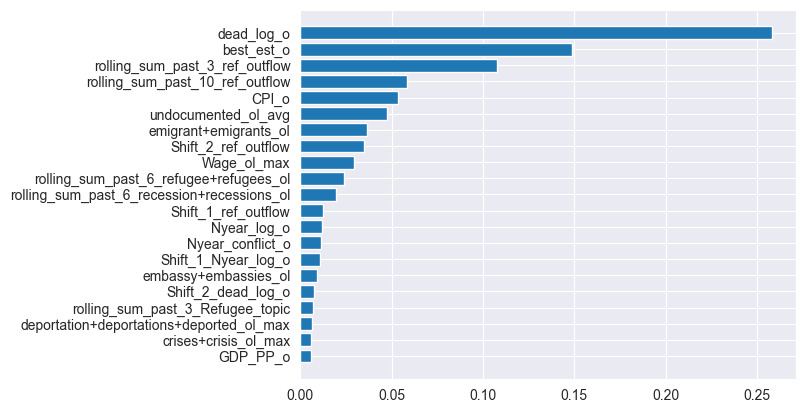

In [88]:
importances = gb_pipe.named_steps['gb'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

Some improvement :) Migration features are not super important but they still improve the model.

In [89]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_mig"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row
predictions['GB_error_aug_mig'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug_mig']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_unhcr', 'RF_error_tw', 'RF_error_aug', 'GB_error', 'actual_range', 'GB_error_aug_mig']].groupby('actual_range').mean()
grouped_errors

C:\Users\danid\AppData\Local\Temp\ipykernel_5288\2797956735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_mig"]=y_pred


,naive_error,RF_error_unhcr,RF_error_tw,RF_error_aug,GB_error,GB_error_aug_mig
actual_range,,,,,,
0-10,10.247788,8.436106,4032.380594,216.483069,1071.257707,988.857650
10-100,23.441176,22.139706,4241.208147,55.675529,978.454704,756.994043
100-1k,709.000000,471.197816,16356.004741,2073.841954,2558.427899,1524.106199
1k-10k,1628.398907,3392.739180,15998.701612,7335.051393,8567.185434,7560.428804
10k-100k,20092.700787,37264.219370,30206.561024,44995.198701,37736.574196,37026.872532
100k+,213039.666667,296695.927333,192939.824667,133158.890667,118768.420322,109852.287723


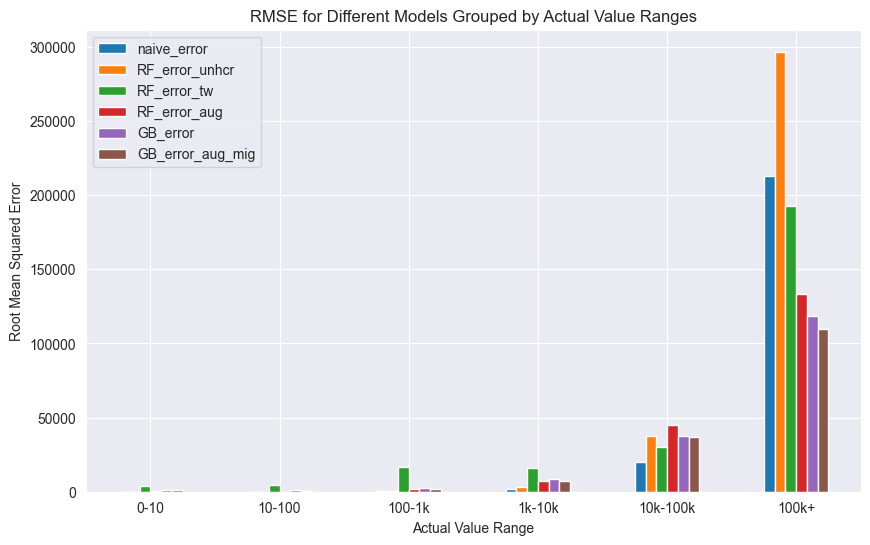

In [90]:
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

#### FRAGILITY INDEX

In [91]:
fsi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   iso                           3332 non-null   object 
 1   year                          3332 non-null   int64  
 2   fsi_overall                   3332 non-null   float64
 3   fsi_security_apparatus        3332 non-null   float64
 4   fsi_factionalized_elites      3332 non-null   float64
 5   fsi_group_grievance           3332 non-null   float64
 6   fsi_economy                   3332 non-null   float64
 7   fsi_economic_inequality       3332 non-null   float64
 8   fsi_human_flight_brain_drain  3332 non-null   float64
 9   fsi_state_legitimacy          3332 non-null   float64
 10  fsi_public_services           3332 non-null   float64
 11  fsi_human_rights              3332 non-null   float64
 12  fsi_demographic_pressures     3332 non-null   float64
 13  fsi

In [92]:
fsi = fsi.rename(columns={'iso': 'iso_o'})

In [93]:
aug_2 = pd.merge(aug_1, fsi, on=["iso_o", "year"], how="left")
print(fsi.shape)
print(aug_1.shape)
print(aug_2.shape)

#aug_2 = aug_2.dropna()
#print(aug_2.shape)

aug_2 = aug_2.fillna(method='bfill')

(3332, 15)
(3281, 671)
(3281, 684)


In [94]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_2.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [95]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_2, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_2 = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + FSI: " + str(mse_aug_2))
print("Relative RMSE to Naive predictions: " + str(mse_aug_2/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration + FSI: 72066.57997369995
Relative RMSE to Naive predictions: 0.6699754268259305


The model is doing worse, even after filling nas not to drop 2005 (backfill).

In [96]:
idp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0                             4900 non-null   int64 
 1   iso_o                     4900 non-null   object
 2   year                      4900 non-null   int64 
 3   conflict_stock_idp_pop_0  4900 non-null   int64 
 4   conflict_stock_idp_pop_1  4900 non-null   int64 
 5   conflict_stock_idp_pop_2  4900 non-null   int64 
 6   conflict_stock_idp_pop_3  4900 non-null   int64 
 7   conflict_stock_idp_pop_4  4900 non-null   int64 
 8   conflict_idp_pop_0        4900 non-null   int64 
 9   conflict_idp_pop_1        4900 non-null   int64 
 10  conflict_idp_pop_2        4900 non-null   int64 
 11  conflict_idp_pop_3        4900 non-null   int64 
 12  conflict_idp_pop_4        4900 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 497.8+ KB


In [97]:
aug_3 = pd.merge(aug_1, idp, on=["iso_o", "year"], how="left")
print(idp.shape)
print(aug_1.shape)
print(aug_3.shape)

(4900, 13)
(3281, 671)
(3281, 682)


In [98]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_3.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [99]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_3, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_3 = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + IDP: " + str(mse_aug_3))
print("Relative RMSE to Naive predictions: " + str(mse_aug_3/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration + IDP: 69104.90215779992
Relative RMSE to Naive predictions: 0.64244184108407


So far:

|         **Model specification**         	| **RMSE/RMSE Naive** 	|
|:---------------------------------------:	|:-------------------:	|
| RF: UNHCR data                          	|        0.7941       	|
| RF: GTrends data (no historic features) 	|        0.6969       	|
| RF: UNHCR + GTrends                     	|        0.6554       	|
| GB: UNHCR + GTrends                     	|        0.6396       	|
| XGB: UNHCR + GTrends                    	|        0.6938       	|
| GB: UNHCR + GTrends + Migration         	|        0.6252       	|
| GB: UNHCR + GTrends + Migration + FSI   	|        0.6974       	|
| GB: UNHCR + GTrends + Migration + IDP   	|        0.6639       	|

That's a lot of sources! 

Now we need to convert conflict, lda, and gdelt to a yearly format.

There are multiple ways to do this. A simple approach is to summarize and do boxplots of the months, aggregating to yearly data. 

Here we have the function agg_year, which produces a boxplot, but also includes the log difference of the data, to represent the average log change for a given year.

However, because this greatly increases dimensionality, we can take fewer values, such as avg, max and log change.

In [100]:
# monthly sources from hannes + gdelt team
conflict = pd.read_csv(path + 'mueller_conflict_forecasts.csv')
lda = pd.read_csv(path + 'lda.csv')
gdelt = pd.read_csv(path + 'gdelt.csv', engine='pyarrow')

In [101]:
def avg_log_diff(series):
    val = np.log1p(series).diff().mean()
    if np.isnan(val):
        return 0
    else:
        return val

# Define the agg_year function
def agg_year(series):
    # Calculate the statistics using numpy
    minimum = np.min(series)
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [minimum, q25, median, q75, maximum, log_diff]

def agg_year_reduc(series):
    # Calculate the statistics using numpy
    mean = np.mean(series)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [mean, maximum, log_diff]

def split_nested_list(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['min','25th','mean','75th','max', 'log_diff'])
    return df

def split_nested_list_reduc(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['mean','max', 'log_diff'])
    return df

def split_df(df):
    new_df = pd.concat([split_nested_list(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

def split_df_reduc(df):
    new_df = pd.concat([split_nested_list_reduc(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

In [102]:
conflict = conflict.drop(columns=['ons_armedconf12_pred_jut_x',
       'ons_armedconf12_pred_jut_y', 'lnbest_pc_12_pred_jut'])

In [103]:
# apply this to conflict data
conflict = conflict.groupby(['isocode', 'year'])[['ons_armedconf12_pred_top_x', 'ons_armedconf12_pred_aug_x', 
                                                   'ons_armedconf12_pred_top_y', 'ons_armedconf12_pred_aug_y', 
                                                  'lnbest_pc_12_pred_top', 'lnbest_pc_12_pred_aug']].agg(agg_year)

conflict = split_df(conflict)

In [104]:
# now the lda data
lda = lda.groupby(['isocode','year'])[['ste_theta0', 'ste_theta1', 'ste_theta2', 'ste_theta3',
       'ste_theta4', 'ste_theta5', 'ste_theta6', 'ste_theta7', 'ste_theta8',
       'ste_theta9', 'ste_theta10', 'ste_theta11', 'ste_theta12',
       'ste_theta13', 'ste_theta14', 'ste_theta0_stock', 'ste_theta1_stock',
       'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock',
       'ste_theta5_stock', 'ste_theta6_stock', 'ste_theta7_stock',
       'ste_theta8_stock', 'ste_theta9_stock', 'ste_theta10_stock',
       'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock',
       'ste_theta14_stock', 'sentiment_stock']].agg(agg_year)
lda = split_df(lda)

In [105]:
gdelt = gdelt.groupby(['isocode','year'])[['count_events_1',
       'count_events_2', 'count_events_3', 'count_events_4', 'count_events_5',
       'count_events_6', 'count_events_7', 'count_events_8', 'count_events_9',
       'count_events_10', 'count_events_11', 'count_events_12',
       'count_events_13', 'count_events_14', 'count_events_15',
       'count_events_16', 'count_events_17', 'count_events_18',
       'count_events_19', 'count_events_20']].agg(agg_year)
gdelt = split_df(gdelt)

In [106]:
print(conflict.shape)
print(lda.shape)
print(gdelt.shape)

(4508, 36)
(4508, 186)
(5725, 120)


#### CONFLICT 

In [107]:
conflict = conflict.reset_index()
conflict = conflict.rename(columns={'isocode': 'iso_o'})


I'm not creating lagged features - because this is conflict forecast, one year lag (the default) should be enough (as we already have actual conflict data from UNHCR that has shifts, as well as rolling sums).

In [108]:
aug_conflict = pd.merge(aug_1, conflict, on=["iso_o", "year"], how="left")
print(aug_conflict.shape)
aug_conflict.head()

(3281, 707)


,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,lnbest_pc_12_pred_top_mean,lnbest_pc_12_pred_top_75th,lnbest_pc_12_pred_top_max,lnbest_pc_12_pred_top_log_diff,lnbest_pc_12_pred_aug_min,lnbest_pc_12_pred_aug_25th,lnbest_pc_12_pred_aug_mean,lnbest_pc_12_pred_aug_75th,lnbest_pc_12_pred_aug_max,lnbest_pc_12_pred_aug_log_diff
0,ABW,59.325933,30.285267,0.0,60.570533,33.396767,23.439967,20.743333,13.068300,0.0,...,0.001450,0.001655,0.001782,-0.000013,0.000347,0.000406,0.000442,0.000480,0.000555,-1.350328e-05
1,ABW,0.000000,0.000000,0.0,5.313000,29.337000,65.373000,11.319000,45.969000,0.0,...,0.000835,0.001100,0.001655,-0.000032,0.000168,0.000230,0.000239,0.000246,0.000288,-1.085586e-05
2,ABW,7.982500,18.025000,0.0,32.960000,10.557500,50.212500,0.000000,32.702500,0.0,...,0.000786,0.000832,0.000896,-0.000016,0.000137,0.000142,0.000147,0.000151,0.000181,-6.937504e-07
3,ABW,22.758667,20.570333,0.0,27.135333,13.567667,56.021333,22.321000,37.201667,0.0,...,0.000943,0.001232,0.001517,-0.000020,0.000141,0.000153,0.000176,0.000186,0.000192,3.608658e-06
4,ABW,14.297000,25.636000,0.0,0.000000,15.776000,62.611000,13.311000,32.045000,0.0,...,0.000745,0.000848,0.000944,-0.000009,0.000120,0.000136,0.000143,0.000150,0.000156,-3.179650e-06


In [109]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_conflict.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [110]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_conflict, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

mse_aug_conflict = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + Conflict(Hannes): " + str(mse_aug_conflict))
print("Relative RMSE to Naive predictions: " + str(mse_aug_conflict/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration + Conflict(Hannes): 66605.08051882386
Relative RMSE to Naive predictions: 0.6192019555480436


#### LDA 

In [111]:
lda = lda.reset_index()
lda = lda.rename(columns={'isocode': 'iso_o'})


In [112]:
aug_lda = pd.merge(aug_1, lda, on=["iso_o", "year"], how="left")
print(aug_lda.shape)
aug_lda.head()


(3281, 857)


,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,ste_theta14_stock_mean,ste_theta14_stock_75th,ste_theta14_stock_max,ste_theta14_stock_log_diff,sentiment_stock_min,sentiment_stock_25th,sentiment_stock_mean,sentiment_stock_75th,sentiment_stock_max,sentiment_stock_log_diff
0,ABW,59.325933,30.285267,0.0,60.570533,33.396767,23.439967,20.743333,13.068300,0.0,...,0.009821,0.010628,0.011793,-0.000158,0.002660,0.004584,0.005842,0.007339,0.013451,0.000591
1,ABW,0.000000,0.000000,0.0,5.313000,29.337000,65.373000,11.319000,45.969000,0.0,...,0.006911,0.007176,0.007742,-0.000045,0.005343,0.008094,0.011715,0.014542,0.018414,-0.000172
2,ABW,7.982500,18.025000,0.0,32.960000,10.557500,50.212500,0.000000,32.702500,0.0,...,0.012220,0.014787,0.017023,0.000880,0.003676,0.006899,0.009598,0.012477,0.017712,-0.000492
3,ABW,22.758667,20.570333,0.0,27.135333,13.567667,56.021333,22.321000,37.201667,0.0,...,0.016022,0.018788,0.022824,-0.000607,0.004804,0.006957,0.007996,0.010729,0.019646,-0.000088
4,ABW,14.297000,25.636000,0.0,0.000000,15.776000,62.611000,13.311000,32.045000,0.0,...,0.013764,0.014244,0.016952,0.000356,0.004993,0.005615,0.007223,0.010538,0.022116,-0.000742


In [113]:

# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_lda.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [114]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_lda, 'target', test_time_start, test_time_end, 'year')

gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_lda = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + LDA(Hannes): " + str(mse_aug_lda))
print("Relative RMSE to Naive predictions: " + str(mse_aug_lda/mse_naive))


RMSE outflows - GTrends + UNHCR covariates + Migration + LDA(Hannes): 80440.81930386806
Relative RMSE to Naive predictions: 0.7478275265317773


Pretty poor results - just in case, I'll try an augmentation with conflict + lda

In [115]:
aug_lda_2 = pd.merge(aug_conflict, lda, on=["iso_o", "year"], how="left")
print(aug_lda_2.shape)
aug_lda_2.head()

(3281, 893)


,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,ste_theta14_stock_mean,ste_theta14_stock_75th,ste_theta14_stock_max,ste_theta14_stock_log_diff,sentiment_stock_min,sentiment_stock_25th,sentiment_stock_mean,sentiment_stock_75th,sentiment_stock_max,sentiment_stock_log_diff
0,ABW,59.325933,30.285267,0.0,60.570533,33.396767,23.439967,20.743333,13.068300,0.0,...,0.009821,0.010628,0.011793,-0.000158,0.002660,0.004584,0.005842,0.007339,0.013451,0.000591
1,ABW,0.000000,0.000000,0.0,5.313000,29.337000,65.373000,11.319000,45.969000,0.0,...,0.006911,0.007176,0.007742,-0.000045,0.005343,0.008094,0.011715,0.014542,0.018414,-0.000172
2,ABW,7.982500,18.025000,0.0,32.960000,10.557500,50.212500,0.000000,32.702500,0.0,...,0.012220,0.014787,0.017023,0.000880,0.003676,0.006899,0.009598,0.012477,0.017712,-0.000492
3,ABW,22.758667,20.570333,0.0,27.135333,13.567667,56.021333,22.321000,37.201667,0.0,...,0.016022,0.018788,0.022824,-0.000607,0.004804,0.006957,0.007996,0.010729,0.019646,-0.000088
4,ABW,14.297000,25.636000,0.0,0.000000,15.776000,62.611000,13.311000,32.045000,0.0,...,0.013764,0.014244,0.016952,0.000356,0.004993,0.005615,0.007223,0.010538,0.022116,-0.000742


In [116]:

# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_lda_2.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])


X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_lda_2, 'target', test_time_start, test_time_end, 'year')

gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_lda_2 = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + Conflict(Hannes) + LDA(Hannes): " + str(mse_aug_lda_2))
print("Relative RMSE to Naive predictions: " + str(mse_aug_lda_2/mse_naive))


RMSE outflows - GTrends + UNHCR covariates + Migration + Conflict(Hannes) + LDA(Hannes): 85847.6850551751
Relative RMSE to Naive predictions: 0.7980930891662804


### GDELT

In [117]:
gdelt = gdelt.reset_index()
gdelt = gdelt.rename(columns={'isocode': 'iso_o'})



In [118]:

aug_gdelt = pd.merge(aug_1, gdelt, on=["iso_o", "year"], how="left")
print(aug_gdelt.shape)
aug_gdelt.head()


(3281, 791)


,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,count_events_19_mean,count_events_19_75th,count_events_19_max,count_events_19_log_diff,count_events_20_min,count_events_20_25th,count_events_20_mean,count_events_20_75th,count_events_20_max,count_events_20_log_diff
0,ABW,59.325933,30.285267,0.0,60.570533,33.396767,23.439967,20.743333,13.068300,0.0,...,0.000000,0.004950,0.040000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,0.000000,0.000000,0.0,5.313000,29.337000,65.373000,11.319000,45.969000,0.0,...,0.000000,0.000000,0.133333,-0.007277,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,7.982500,18.025000,0.0,32.960000,10.557500,50.212500,0.000000,32.702500,0.0,...,0.016556,0.037393,0.076923,0.000917,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,22.758667,20.570333,0.0,27.135333,13.567667,56.021333,22.321000,37.201667,0.0,...,0.000000,0.005774,0.200000,0.001388,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,14.297000,25.636000,0.0,0.000000,15.776000,62.611000,13.311000,32.045000,0.0,...,0.011753,0.025073,0.173077,0.011851,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:

# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_gdelt.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])


In [120]:

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_gdelt = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT: " + str(mse_aug_gdelt))
print("Relative RMSE to Naive predictions: " + str(mse_aug_gdelt/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT: 68194.80953940534
Relative RMSE to Naive predictions: 0.6339810581430374


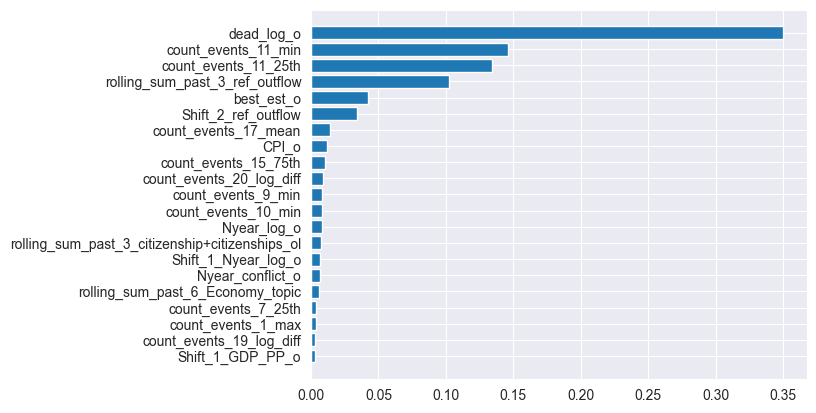

In [121]:
importances = gb_pipe.named_steps['gb'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)


Even though the GDELT features are not improving the overall relative RMSE, they are picked up by the model as very relevant.

In [122]:
predictions = predictions.drop(columns=["y_pred_aug_gdelt_x", "y_pred_aug_gdelt_y"])

KeyError: "['y_pred_aug_gdelt_x', 'y_pred_aug_gdelt_y'] not found in axis"

In [ ]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_gdelt"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row
predictions['GB_error_aug_gdelt'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug_gdelt']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_unhcr', 'RF_error_tw', 'RF_error_aug', 'GB_error', 'actual_range', 'GB_error_aug_mig', 'GB_error_aug_gdelt']].groupby('actual_range').mean()
grouped_errors

C:\Users\danid\AppData\Local\Temp\ipykernel_13224\2712757760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_gdelt"]=y_pred


,naive_error,RF_error_unhcr,RF_error_tw,RF_error_aug,GB_error,GB_error_aug_mig,GB_error_aug_gdelt
actual_range,,,,,,,
0-10,10.247788,8.563097,3747.371188,212.711485,1071.257707,988.857650,867.848231
10-100,23.441176,22.402353,2898.244765,55.749588,978.454704,756.994043,1154.801965
100-1k,709.000000,487.627126,14848.117184,1925.881954,2547.222698,1524.106199,1533.088096
1k-10k,1628.398907,3424.444208,16973.965246,7406.019918,7720.045877,7182.018061,6119.777104
10k-100k,20092.700787,36851.597165,31339.548543,49888.491260,41329.127175,44962.174841,32540.201943
100k+,213039.666667,307095.343333,188535.822667,133090.505333,107238.254091,99630.734930,101101.962303


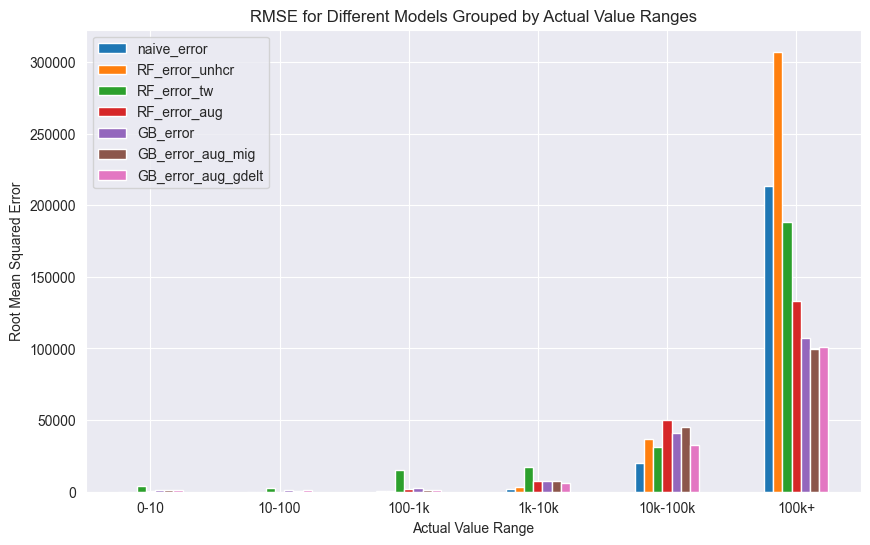

In [ ]:
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

Final comparisons:

|                        **Model specification**                       	| **RMSE/RMSE Naive** 	|
|:--------------------------------------------------------------------:	|:-------------------:	|
| RF: UNHCR data                                                       	|        0.7941       	|
| RF: GTrends data (no historic features)                              	|        0.6969       	|
| RF: UNHCR + GTrends                                                  	|        0.6554       	|
| GB: UNHCR + GTrends                                                  	|        0.6396       	|
| XGB: UNHCR + GTrends                                                 	|        0.6938       	|
| GB: UNHCR + GTrends + Migration                                      	|        0.6252       	|
| GB: UNHCR + GTrends + Migration + FSI                                	|        0.6974       	|
| GB: UNHCR + GTrends + Migration + IDP                                	|        0.6639       	|
| GB: UNHCR + GTrends + Migration + Conflict forecast                  	|        0.6307       	|
| GB: UNHCR + GTrends + Migration + Conflict forecast  (extended)      	|        0.6341       	|
| GB: UNHCR + GTrends + Migration + LDA (Conflict forecast)            	|        0.7276       	|
| GB: UNHCR + GTrends + Migration + LDA (Conflict forecast) (extended) 	|        0.7125       	|
| GB: UNHCR + GTrends + Migration + Conflict forecast + LDA            	|        0.7485       	|
| GB: UNHCR + GTrends + Migration + Conflict forecast + LDA (extended) 	|        0.6770       	|
| GB: UNHCR + GTrends + Migration + GDELT                              	|        0.6722       	|
| GB: UNHCR + GTrends + Migration + GDELT (extended)                   	|        0.6264       	|

### Hyperparameter tunning on the GDELT model (in progress)

In [138]:
aug_gdelt.shape

(3281, 791)

In [140]:
# Define the model
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
gb_model = GradientBoostingRegressor()

# Define the parameter grid
param_grid = {
    'model__max_features': [20, 25, 50, 100, 130, 150, 300, 400],
    'model__n_estimators': [100, 120, 150, 200, 250, 300, 400],
    'model__max_depth': [5, 6, 8, 10, 20, 30, 40],
    'model__learning_rate': [0.01],
    'model__random_state': [SEED],
    'model__min_samples_split': [2, 5, 7, 10, 15, 20]
}

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', transform_cols),
    ('model', gb_model)
])

# Create the GridSearchCV object
# grid_search = HalvingGridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search = HalvingGridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

grid_search.fit(X_train, y_train)

# Retrieve the best model and its corresponding parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_params)

y_pred = grid_search.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

mse_aug_tuned = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT (tunned): " + str(mse_aug_tuned))
print("Relative RMSE to Naive predictions: " + str(mse_aug_tuned / mse_naive))

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 10
max_resources_: 2509
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2352
n_resources: 10
Fitting 5 folds for each of 2352 candidates, totalling 11760 fits
----------
iter: 1
n_candidates: 784
n_resources: 30
Fitting 5 folds for each of 784 candidates, totalling 3920 fits
----------
iter: 2
n_candidates: 262
n_resources: 90
Fitting 5 folds for each of 262 candidates, totalling 1310 fits
----------
iter: 3
n_candidates: 88
n_resources: 270
Fitting 5 folds for each of 88 candidates, totalling 440 fits
----------
iter: 4
n_candidates: 30
n_resources: 810
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 5
n_candidates: 10
n_resources: 2430
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__max_features': 130, 'model__min_samples_split': 10, 'model__n_estimators': 

Results with HalvingGridSearch:

30 min to train on these parameters:
param_grid = {
    'model__max_features': [20, 25, 50, 100, 130, 150, 300, 400],
    'model__n_estimators': [100, 120, 150, 200, 250, 300, 400],
    'model__max_depth': [5, 6, 8, 10, 20, 30, 40],
    'model__learning_rate': [0.01],
    'model__random_state': [SEED],
    'model__min_samples_split': [2, 5, 7, 10, 15, 20]
}


**Results**


Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__max_features': 130, 'model__min_samples_split': 10, 'model__n_estimators': 200, 'model__random_state': 12}
RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT (tunned): 66800.80596174637
Relative RMSE to Naive predictions: **0.6210215401212336**

In [142]:
predictions_selec = predictions[["iso_o", "year", "y_pred_aug_mig", "y_pred_aug_gdelt"]]

In [143]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_gdelt_tunned"]=y_pred

predictions_selec = pd.merge(predictions_selec, ind, on=["iso_o", "year"], how="left")

C:\Users\danid\AppData\Local\Temp\ipykernel_13224\1643805699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_gdelt_tunned"]=y_pred


In [144]:
predictions_selec.to_csv("../../best predictions/outflow_pred_2.csv", index=False)

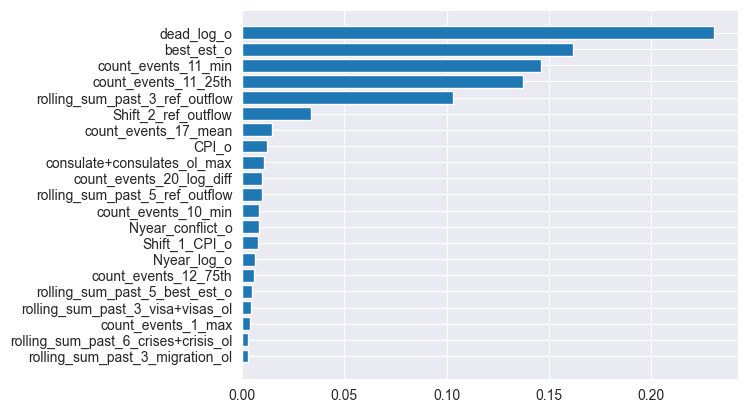

In [145]:
importances = gb_pipe.named_steps['gb'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)


C:\Users\danid\AppData\Local\Temp\ipykernel_13224\2478101029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_gdelt_tunned"]=y_pred


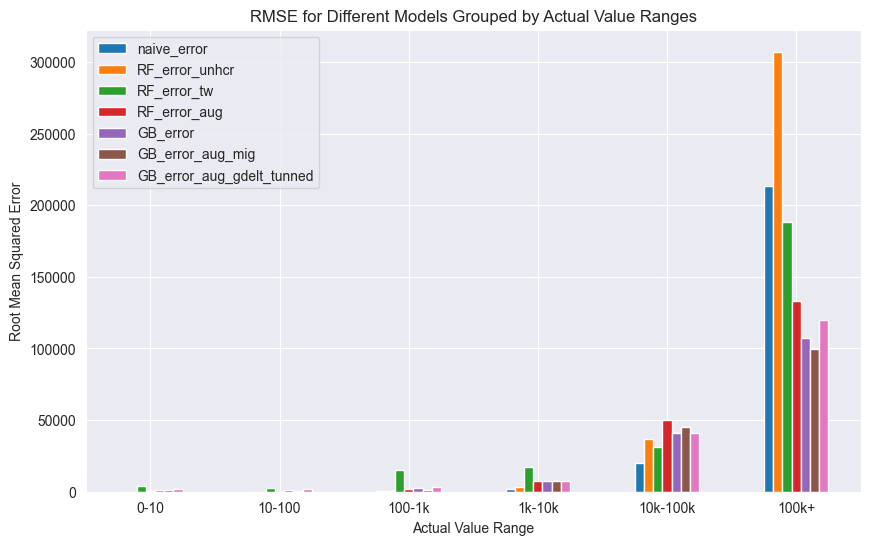

In [146]:

ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_gdelt_tunned"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row
predictions['GB_error_aug_gdelt_tunned'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug_gdelt_tunned']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_unhcr', 'RF_error_tw', 'RF_error_aug', 'GB_error', 'actual_range', 'GB_error_aug_mig', 'GB_error_aug_gdelt_tunned']].groupby('actual_range').mean()


grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()



Trying log transformation of the y variable for the best performing models

In [125]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_1.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_1, 'target', test_time_start, test_time_end, 'year')

# Add a small constant to handle zero values
epsilon = 1e-8
y_train_log = np.log(y_train + epsilon)

gb_pipe.fit(X_train, y_train_log)

# Predict on test set and transform back to original scale
y_pred_log = gb_pipe.predict(X_test)
y_pred = np.exp(y_pred_log) 

mse_aug_1 = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration: " + str(mse_aug_1))
print("Relative RMSE to Naive predictions: " + str(mse_aug_1 / mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration: 57747.491939228064
Relative RMSE to Naive predictions: 0.5368563427629096


In [126]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_mig_logs"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row
predictions['GB_error_mig_logs'] = np.sqrt((predictions['y_test'] - predictions['y_pred_mig_logs']) ** 2)


C:\Users\danid\AppData\Local\Temp\ipykernel_5288\4092473772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_mig_logs"]=y_pred


In [127]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_gdelt.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

# Add a small constant to handle zero values
epsilon = 1e-8
y_train_log = np.log(y_train + epsilon)

gb_pipe.fit(X_train, y_train_log)

# Predict on test set and transform back to original scale
y_pred_log = gb_pipe.predict(X_test)
y_pred = np.exp(y_pred_log) 

mse_aug_gdelt = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration: " + str(mse_aug_gdelt))
print("Relative RMSE to Naive predictions: " + str(mse_aug_gdelt / mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration: 50972.836071124155
Relative RMSE to Naive predictions: 0.47387495862496215


In [128]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_gdelt_logs"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")



C:\Users\danid\AppData\Local\Temp\ipykernel_5288\3312598400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_gdelt_logs"]=y_pred


In [129]:
# Compute RMSE for each row
predictions['GB_error_aug_gdelt_logs'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug_gdelt_logs']) ** 2)


In [131]:
predictions.columns

Index(['iso_o', 'year', 'y_test', 'y_naive', 'y_unhcr', 'y_pred_tw',
       'naive_error', 'RF_error_tw', 'actual_range', 'y_pred_aug',
       'RF_error_aug', 'RF_error_unhcr', 'y_pred_gb', 'GB_error',
       'y_pred_aug_mig', 'GB_error_aug_mig', 'y_pred_mig_logs',
       'GB_error_mig_logs', 'y_pred_aug_gdelt_logs',
       'GB_error_aug_gdelt_logs'],
      dtype='object')

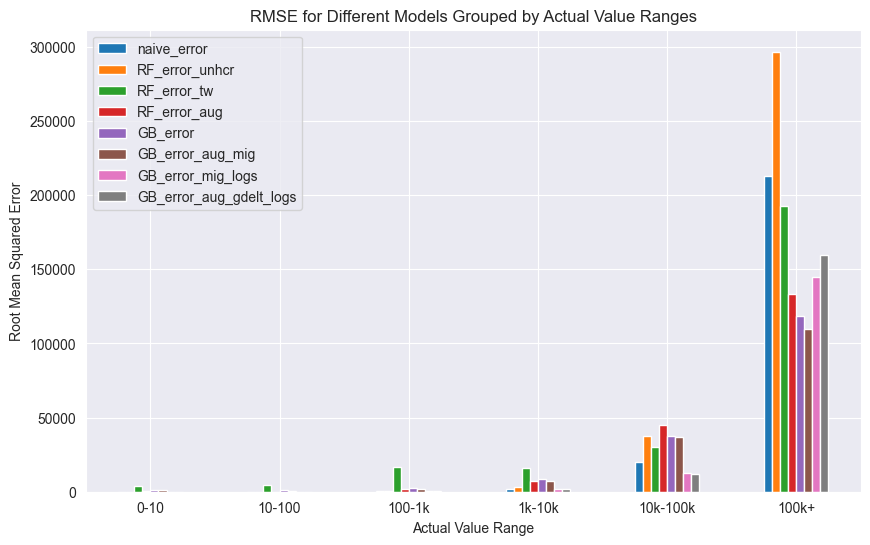

In [133]:
# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'RF_error_unhcr', 'RF_error_tw', 'RF_error_aug', 'GB_error', 'actual_range', 'GB_error_aug_mig', 'GB_error_mig_logs', 'GB_error_aug_gdelt_logs']].groupby('actual_range').mean()


grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

### Checking different performances by internet penetration levels

In [134]:
predictions

,iso_o,year,y_test,y_naive,y_unhcr,y_pred_tw,naive_error,RF_error_tw,actual_range,y_pred_aug,RF_error_aug,RF_error_unhcr,y_pred_gb,GB_error,y_pred_aug_mig,GB_error_aug_mig,y_pred_mig_logs,GB_error_mig_logs,y_pred_aug_gdelt_logs,GB_error_aug_gdelt_logs
0,ABW,2018,0.0,1.0,0.25,10910.97,1.0,10910.97,0-10,0.510,0.510,0.25,508.021376,508.021376,564.095233,564.095233,1.218444e-06,1.218444e-06,0.000013,0.000013
1,ABW,2019,1.0,0.0,0.65,11311.04,1.0,11310.04,0-10,0.550,0.450,0.35,508.021376,507.021376,564.095233,563.095233,2.505057e-07,9.999997e-01,0.000006,0.999994
2,ABW,2020,0.0,1.0,0.38,12818.41,1.0,12818.41,0-10,0.730,0.730,0.38,508.021376,508.021376,564.095233,564.095233,2.085760e-07,2.085760e-07,0.000018,0.000018
3,ABW,2021,0.0,0.0,0.39,11310.12,0.0,11310.12,0-10,0.430,0.430,0.39,508.021376,508.021376,564.095233,564.095233,1.254342e-05,1.254342e-05,0.000097,0.000097
4,AFG,2018,118015.0,128373.0,296406.37,183832.49,10358.0,65817.49,100k+,375290.560,257275.560,178391.37,143237.008867,25222.008867,114796.944193,3218.055807,9.212227e+04,2.589273e+04,83920.203844,34094.796156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,ZMB,2021,73.0,86.0,128.48,5364.65,13.0,5291.65,10-100,144.160,71.160,55.48,629.064684,556.064684,659.147337,586.147337,1.435026e+02,7.050255e+01,133.067399,60.067399
780,ZWE,2018,1908.0,4523.0,7026.00,13475.58,2615.0,11567.58,1k-10k,19599.040,17691.040,5118.00,14259.521394,12351.521394,12250.597474,10342.597474,8.953286e+03,7.045286e+03,8654.227926,6746.227926
781,ZWE,2019,3371.0,1908.0,5026.18,16466.14,1463.0,13095.14,1k-10k,40347.655,36976.655,1655.18,66114.454289,62743.454289,58524.067099,55153.067099,8.845640e+03,5.474640e+03,5197.495325,1826.495325
782,ZWE,2020,1196.0,3371.0,3243.44,14028.61,2175.0,12832.61,1k-10k,17522.940,16326.940,2047.44,61332.924580,60136.924580,56384.253857,55188.253857,7.253243e+03,6.057243e+03,4459.454640,3263.454640


In [135]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

internet_long = internet_long.copy().fillna(-99)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})

internet_long.internet = internet_long.internet.astype(int)

In [136]:
predic_analysis = pd.merge(predictions, internet_long, on=["iso_o", "year"], how="left")

In [137]:
# Define the ranges for grouping the actual values
ranges = [-99, 10, 30, 50, 70, 100]  # Modify the ranges as per your requirements
labels = ['NA', '0-10', '10-30', '30-50', '50-70']  # Labels for the groups
predic_analysis['internet_cat'] = pd.cut(predic_analysis['internet'], ranges, labels=labels, include_lowest=True)



In [138]:
# Filter the columns that contain "error" in their name
error_columns = predic_analysis.filter(like='error')

# Add the "internet_cat" column to the filtered DataFrame
error_columns['internet_cat'] = predic_analysis['internet_cat']

# Group by "internet_cat" and calculate the mean
grouped_errors = error_columns.groupby('internet_cat').mean()


C:\Users\danid\AppData\Local\Temp\ipykernel_5288\4086883462.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_columns['internet_cat'] = predic_analysis['internet_cat']


In [139]:
grouped_errors

,naive_error,RF_error_tw,RF_error_aug,RF_error_unhcr,GB_error,GB_error_aug_mig,GB_error_mig_logs,GB_error_aug_gdelt_logs
internet_cat,,,,,,,,
NA,67894.707865,87111.128652,62432.166910,66830.395056,55731.590502,55408.341261,61037.045636,60345.719884
0-10,13407.494737,18493.401421,26469.948053,20368.196000,16128.694019,15302.604181,6847.042965,6624.445524
10-30,14363.180000,17958.928100,22234.459450,26080.007000,24200.229431,24091.211386,12351.654296,12190.488978
30-50,2541.870504,14980.750683,7748.291439,2294.572014,8504.076238,7823.765375,2263.476541,2261.625705
50-70,1246.137931,11657.544239,4225.051796,985.864511,4605.824543,3402.842859,1021.834906,1018.197115


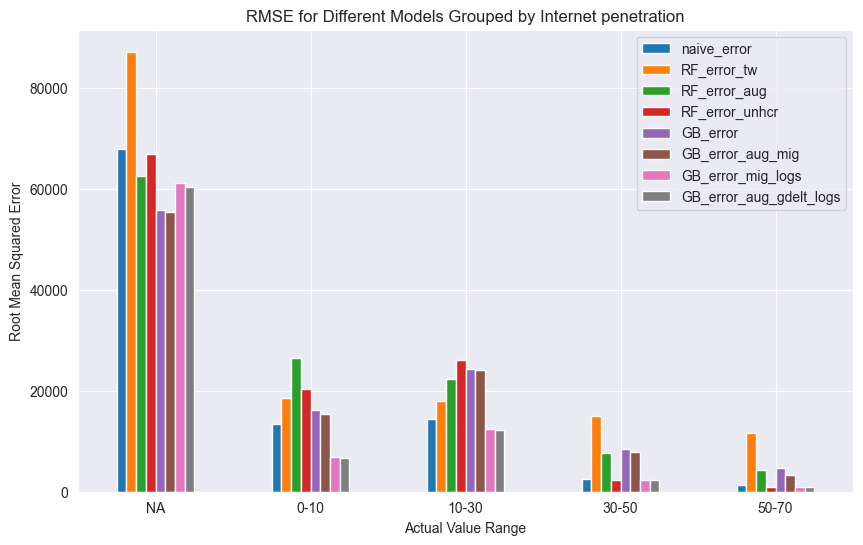

In [140]:
# Compute mean RMSE for each group

grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Internet penetration')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()


In [200]:
predic_analysis_missing = predic_analysis[predic_analysis.internet==-99]

In [205]:
import pycountry
iso3_codes= predic_analysis_missing.iso_o.unique()
country_names = []
for code in iso3_codes:
    try:
        country = pycountry.countries.get(alpha_3=code)
        country_names.append(country.name)
    except KeyError:
        country_names.append(None)

print(country_names)

['Aruba', 'Afghanistan', 'Andorra', 'Antigua and Barbuda', 'Congo', 'Comoros', 'Dominica', 'Eritrea', 'Micronesia, Federated States of', 'Equatorial Guinea', 'Guyana', 'Cambodia', 'Saint Kitts and Nevis', 'Libya', 'Marshall Islands', 'Niger', 'Nauru', 'Palau', 'Papua New Guinea', 'Puerto Rico', 'Sudan', 'Solomon Islands', 'Sierra Leone', 'San Marino', 'Somalia', 'South Sudan', 'Syrian Arab Republic', 'Tajikistan', 'Turkmenistan', 'Trinidad and Tobago', 'Tuvalu', 'Venezuela, Bolivarian Republic of', 'Yemen']
